In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print(tf.__version__)
# import keras
# print(keras.__version__)

In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
from matplotlib import pyplot
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%matplotlib inline
import random

# %tensorflow_version 1.x
import tensorflow as tf

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split

# Data Class Weight
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard



def FER_Model(input_shape):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    #             LSTM Version            #
    # net = layers.LSTM(10, return_sequences=False)(visible)
    net = layers.Dense(64, activation='relu')(visible)
    # net = layers.Dropout(0.2)(net)


    # net = layers.LSTM(5, return_sequences=True)(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dropout(0.2)(net)

    # net = layers.LSTM(5, return_sequences=True)(visible)
    # net = layers.Dense(16, activation='relu')(net)
    # # net = layers.Dropout(0.2)(net)

    # net = layers.LSTM(1, return_sequences=False)(visible)
    # net = layers.Dense(8, activation='relu')(net)
    # net = layers.Dropout(0.5)(net)

    # net = layers.Conv2D(64, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    # shortcut_1 = net

    # net = layers.Conv2D(32, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    # shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    print(model.summary())
    
    return model



# seed = 1213
# np.random.seed(seed)
# random.seed(seed)
# tf.random.set_random_seed(seed)
# tf.random.set_seed(seed)

num_classes = 2
batch_size = 30


gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/'


model_range = range(1180, 1214)
features = [[0, 1, 2, 3], [i for i in range(4, 10)], [i for i in range(10, 16)], [i for i in range(16, 18)],
            [i for i in range(18, 21)], [i for i in range(21, 24)], [i for i in range(24, 26)], [i for i in range(26, 29)],
            [i for i in range(29, 31)]]
feature_name = ['ohlc', 'minor ST', 'Major ST', 'EMA', 'minor ST Trend', 'Major ST Trend', 'CB', 'Fisher', 'Trix']
# break

for model_num in model_range:

  # try:

    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % model_num)
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s.npy' % model_num).reshape(-1, 1)

    #         Feature Selection      #
    for feature_i in range(len(features)):
      # Made_X = Made_X_[:, :, [-4]]
      # Made_X = Made_X_[:, :, :4]
      Made_X = Made_X_[:, :, features[feature_i]]

      #             Train Limitation          #
      # Made_X = Made_X[-limit_train_size:]
      # Made_Y = Made_Y[-limit_train_size:]
      # print(Made_X.shape)
      # print(Made_Y.shape)
      # break

      row = Made_X.shape[1]
      col = Made_X.shape[2]

      X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                          shuffle=False)

      print('X_train.shape :', X_train.shape)
      print('X_val.shape :', X_val.shape)


      label = Y_train.reshape(-1, )
      # print(label.shape)

      Y_train = np_utils.to_categorical(Y_train, num_classes)
      Y_val = np_utils.to_categorical(Y_val, num_classes)
      
      print('Y_train.shape :', Y_train.shape)
      print('Y_val.shape :', Y_val.shape)

      
      #         Get Class_Weights (--> should be considered only for TrainSet)       #
      class_weights = class_weight.compute_class_weight('balanced', 
                                                        classes=np.unique(label),
                                                        y=label)
      class_weights = dict(enumerate(class_weights))
      print(class_weights)
      # quit()

      model = FER_Model((row, col))
      opt = Adam(lr=0.0001, decay=1e-6)

      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
          
      filepath = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (model_num, feature_i)
      checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
      checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                                histogram_freq=0,
                                write_graph=True,
                                write_images=True)
      checkpoint3 = EarlyStopping(monitor='val_accuracy', patience=100)
      callbacks_list = [checkpoint, checkpoint2, checkpoint3]

      # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

      # we iterate 200 times over the entire training set
      num_epochs = 1000
      history = model.fit(X_train, Y_train,
                          steps_per_epoch=int(len(X_train) / batch_size), 
                          epochs=num_epochs,  
                          verbose=2,  
                          callbacks=callbacks_list,
                          class_weight=class_weights,
                          validation_data=(X_val, Y_val),  
                          validation_steps=int(len(X_val) / batch_size),
                          shuffle=False)
      
    # except Exception as e:
    #   print('Error occured :', e)


Streaming output truncated to the last 5000 lines.
Epoch 00090: val_accuracy did not improve from 0.75519
52/52 - 0s - loss: 0.4442 - accuracy: 0.7542 - val_loss: 0.5073 - val_accuracy: 0.7418
Epoch 91/1000

Epoch 00091: val_accuracy did not improve from 0.75519
52/52 - 0s - loss: 0.4467 - accuracy: 0.7573 - val_loss: 0.5021 - val_accuracy: 0.7418
Epoch 92/1000

Epoch 00092: val_accuracy did not improve from 0.75519
52/52 - 0s - loss: 0.4463 - accuracy: 0.7586 - val_loss: 0.5114 - val_accuracy: 0.7404
Epoch 93/1000

Epoch 00093: val_accuracy did not improve from 0.75519
52/52 - 0s - loss: 0.4443 - accuracy: 0.7561 - val_loss: 0.5104 - val_accuracy: 0.7404
Epoch 94/1000

Epoch 00094: val_accuracy did not improve from 0.75519
52/52 - 0s - loss: 0.4416 - accuracy: 0.7698 - val_loss: 0.5083 - val_accuracy: 0.7404
Epoch 95/1000

Epoch 00095: val_accuracy did not improve from 0.75519
52/52 - 0s - loss: 0.4324 - accuracy: 0.7661 - val_loss: 0.5080 - val_accuracy: 0.7404
Epoch 96/1000

Epoch 0

FileNotFoundError: ignored

### ***Backtest***

In [10]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc


trade_on = True
show_trade_data = False

input_data_length = 30 # <-- Need for Back-Test
test_model_range = range(1044, 1078)
all_pair_profit_result = list()
for model_num, test_model_num in zip(model_range, test_model_range):

  # try:

    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % model_num)
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s.npy' % model_num).reshape(-1, 1)

    Made_X_test_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % test_model_num)
    #     for trade, ohlc data    #
    Made_Z_test = np.load(gdrive_path + 'Made_X/Made_Z %s.npy' % test_model_num)

    # Made_X2 = np.load(gdrive_path + 'Made_X/Made_X 30_%s.npy' % (30, 219))
    # Made_Y2 = np.load(gdrive_path + 'Made_X/Made_Y 30_%s.npy' % (30, 219))

    model_list = features

    total_precision_result = list()
    total_f1_result = list()
    total_auc_result = list()
    total_profit_result = list()
    total_pr = list()
    plt.figure(figsize=(20, 10))

    #         Feature Selection      #
    for specific_num in range(len(model_list)):
      # Made_X = Made_X_[:, :, [-4]]
      # Made_X = Made_X_[:, :, :4]
      Made_X = Made_X_[:, :, features[specific_num]]
      # Made_X2 = Made_X2[:, :, [0, 2, 3, 1]]

      #         Train Limit         #
      # Made_X = Made_X[-4000:]
      # Made_Y = Made_Y[-4000:]
      Made_X_test = Made_X_test_[:, :, :4]
      print('Made_X.shape :', Made_X.shape)
      print('Made_Y.shape :', Made_Y.shape)
      print('Made_X_test.shape :', Made_X_test.shape)
      print('Made_Z_test.shape :', Made_Z_test.shape)

      # print('min(Made_Z_test) :', np.min(Made_Z_test))
      # print(sum(sum(Made_X != Made_X2)))
      # break

      row = Made_X.shape[1]
      col = Made_X.shape[2]

      X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                          shuffle=False)
      X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
      X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

      Y_train = Y_train.astype('float32')
      Y_val = Y_val.astype('float32')
      
      X_test = Made_X_test
      print('np.unique(Made_Y) :', np.unique(Made_Y, return_counts=True))
      print('np.unique(Y_train) :', np.unique(Y_train, return_counts=True))
      print('np.unique(Y_val) :', np.unique(Y_val, return_counts=True))

      Y_train = np_utils.to_categorical(Y_train, num_classes)
      Y_val = np_utils.to_categorical(Y_val, num_classes)
      
      print('X_train.shape :', X_train.shape)
      print('X_val.shape :', X_val.shape)

      print('model_num :', model_num)

      model_path = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (model_num, specific_num)
      model = load_model(model_path)

      #     val, train -> confidence 와 evaluate 용
      val_y_pred_ = model.predict(X_val, verbose=1)
      train_y_pred_ = model.predict(X_train, verbose=1)

      #     test -> profit 용
      # test_y_pred_ = model.predict(X_test, verbose=1)

      train_val_predmin = min(min(val_y_pred_[:, [1]]), min(train_y_pred_[:, [1]]))
      train_val_predmax = max(max(val_y_pred_[:, [1]]), max(train_y_pred_[:, [1]]))

      
      for index, y_pred_ in enumerate([val_y_pred_, train_y_pred_]):

        # print('len(y_pred_) :', len(y_pred_))
        target_column = y_pred_[:, [1]]
        # column_min, column_max = train_y_pred_.min(),train_y_pred_.max()
        column_min, column_max = min(target_column),max(target_column)
        # print(column_min, column_max)

        if index == 0:
          _, model_acc = model.evaluate(X_val, Y_val, batch_size=batch_size)
        elif index == 1:
          _, model_acc = model.evaluate(X_train, Y_train, batch_size=batch_size)

        x_ticks = np.arange(0.5, 1, 0.005)
        # x_ticks = [0.6]

        precision_result = list()
        f1_result = list()
        profit_result = list()        
        for confidence in x_ticks:
          # confidence = 0.9

          # if column_max < 0.5:
          #   break
          # else:
          #   scaled_confidence = .5 + (column_max - .5) * confidence
          # scaled_confidence = column_min + (column_max - column_min) * confidence
          scaled_confidence = train_val_predmin + (train_val_predmax - train_val_predmin) * confidence
          # scaled_confidence = confidence

          # print(scaled_confidence)
          # print('confidence :', confidence)

          y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )

          pred_true, real_true, true_true = 0, 0, 0   

          #     결국, Categorical 은 index 값으로 value 를 나타내는 것    #
          # t_te = np.argmax(Y_test, axis=1)            
          if index == 0:
            t_te = np.argmax(Y_val, axis=1)
          elif index == 1:
            t_te = np.argmax(Y_train, axis=1)

          #       Trading Session, Accumulate Profit     #
          elif index == 2:

              accumulated_profit = 1.

              if trade_on:
                tp_ratio = 3
                target_percentage = 0.05
                sl_least_gap_ratio = 0.05

                long_marker_x = list()
                long_marker_y = list()
                tp_marker_x = list()
                tp_marker_y = list()
                sl_marker_x = list()
                sl_marker_y = list()
                tp_level_list_x = list()
                tp_level_list_y = list()
                sl_level_list_x = list()
                sl_level_list_y = list()

                #         This column order should be changed     #
                high, low, close = np.split(Made_Z_test[:, 1:4], 3, axis=1) # <-- Column Order should be changed
                # break
                i = input_data_length
                while (i < len(y_pred)):

                  #     Long    #
                  if y_pred[i] == 1:  

                    long_sl = np.min(low[i + 1 -input_data_length:i + 1])
                    short_sl = np.max(high[i + 1 -input_data_length:i + 1])
                    tp_level_0 = (close[i] - long_sl) * tp_ratio * 1/3 + close[i]
                    tp_level_1 = (close[i] - long_sl) * tp_ratio * 2/3 + close[i]
                    tp_level = (close[i] - long_sl) * tp_ratio + close[i]
                    tp_count = 3

                    #       Consider 'sl_least_gap'     #
                    if not close[i] >= long_sl + (short_sl - long_sl) * sl_least_gap_ratio:
                      i += 1
                      if i >= len(y_pred):
                        break
                      continue

                    if show_trade_data: print(i, 'long')
                    pred_true += 1

                    long_marker_x.append(i)
                    long_marker_y.append(close[i])

                    if i + 1 >= len(y_pred):
                      break
                    
                    for j in range(i + 1, len(y_pred)):

                      if show_trade_data: print(long_sl, low[j], high[j], tp_level)
                      tp_level_list_x.append(j)
                      tp_level_list_y.append(tp_level)

                      if high[j] > tp_level_0 and tp_count == 3:
                        accumulated_profit *= 1 + target_percentage * tp_ratio * 1/3 * .25
                        tp_count -= 1
                      elif high[j] > tp_level_0 and tp_count == 2:
                        accumulated_profit *= 1 + target_percentage * tp_ratio * 2/3 * .25
                        tp_count -= 1
                      elif high[j] > tp_level and tp_count == 1:
                        accumulated_profit *= 1 + target_percentage * tp_ratio * .5
                        if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)  
                        tp_marker_x.append(j)
                        tp_marker_y.append(high[j])
                        real_true += 1
                        break
                      
                      elif low[j] < long_sl:
                        accumulated_profit *= 1 - target_percentage
                        if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)          
                        sl_marker_x.append(j)
                        sl_marker_y.append(low[j])
                        break

                    i = j

                  i += 1
                  # print('i, len(y_pred) :', i, len(y_pred))
                  if i >= len(y_pred):
                    break

              profit_result.append(accumulated_profit)

          if index != 2:

            for i in range(len(y_pred)):
              if y_pred[i] == 1:  
                pred_true += 1
                if t_te[i] == y_pred[i]:
                  real_true += 1

            #     precision   #
            # precision = precision_score(t_te, y_pred) * 100
            f1 = f1_score(t_te, y_pred) * 100

          if pred_true != 0:
            true_true = real_true / pred_true * 100
            # print('precision, true_true :', precision, true_true)

          precision_result.append(true_true)
          f1_result.append(f1)

          # print('Real True / Pred True : %s / %s' % (real_true, pred_true))
          # print('Accuracy : %.2f %%' % (true_true))
          # print('Accumulated Profit : %.3f' % accumulated_profit)
          # print()
        
        fpr, tpr, thr = roc_curve(t_te, target_column)
        auc_ = auc(fpr, tpr) * 100

        total_precision_result.append(precision_result)
        total_f1_result.append(f1_result)
        total_auc_result.append(auc_)
        total_pr.append((fpr, tpr))
        
        if index == 2:
          total_profit_result.append(profit_result)   

      all_pair_profit_result.append(profit_result)

        #          Show Entry Point       #
        # plt.subplot(2, 1, index + 1 + model_i * 1)
        # plt.plot(close)
        # plt.plot(long_marker_x, long_marker_y, 'o', color='green')             
        # plt.plot(tp_marker_x, tp_marker_y, 'o', color='blue')
        # plt.plot(sl_marker_x, sl_marker_y, 'o', color='red')
        # plt.plot(tp_level_list_x, tp_level_list_y, '.', color='blue')
        # plt.title('Accumulated Profit : %.3f' % accumulated_profit, color='white')

    #       This Indent Line should be match with Loop for divesified Loaded Model     #
    print('len(total_precision_result) :', len(total_precision_result))
    print('len(total_f1_result) :', len(total_f1_result))
    print('len(total_auc_result) :', len(total_auc_result))
    print('len(total_profit_result) :', len(total_profit_result))

    #         Show True True Acc by confidence    #
    plt.subplot(2, 7, 1)
    for i in range(len(model_list)):
      plt.plot(x_ticks, total_precision_result[i], label='%s' % i)
    plt.axhline(50, linestyle='--', color='red')
    plt.ylim(-5, 105)
    plt.legend()
    plt.title('Val Precision', color='white', fontsize=10)

    plt.subplot(2, 7, 2)
    for i in range(len(model_list)):
      plt.plot(x_ticks, total_precision_result[i + len(model_list)], label='%s' % i)
    plt.axhline(50, linestyle='--', color='red')
    plt.ylim(-5, 105)
    plt.legend()
    plt.title('Train Precision', color='white', fontsize=10)

    print('last index =', index)
    if index == 2:
      plt.subplot(273)
      for i in range(len(model_list)):
        plt.plot(x_ticks, total_precision_result[i + len(model_list) * 2], label='%s' % i)
      plt.axhline(50, linestyle='--', color='red')
      plt.ylim(-5, 105)
      plt.legend()
      plt.title('Test Precision', color='white', fontsize=10)
    
    plt.subplot(2, 7, 8)
    for i in range(len(model_list)):
      plt.plot(x_ticks, total_f1_result[i], label='%s' % i)
    plt.axhline(50, linestyle='--', color='red')
    plt.ylim(-5, 105)
    plt.legend()
    plt.title('Val F1', color='white', fontsize=10) 

    plt.subplot(2, 7 ,9)
    for i in range(len(model_list)):
      plt.plot(x_ticks, total_f1_result[i + len(model_list)], label='%s' % i)
    plt.axhline(50, linestyle='--', color='red')
    plt.ylim(-5, 105)
    plt.legend()
    plt.title('Train F1', color='white', fontsize=10)   

    plt.subplot(2, 7, 10)    
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(len(model_list)):
      fpr, tpr = total_pr[i]
      plt.plot(fpr, tpr, label='%s %.2f' % (i, total_auc_result[i]))
    plt.legend()
    plt.title('Val AUC', color='white', fontsize=10)   

    plt.subplot(2, 7, 11)    
    plt.plot([0, 1], [0, 1], 'k--')
    for i in range(len(model_list)):
      fpr, tpr = total_pr[i + len(model_list)]
      plt.plot(fpr, tpr, label='%s %.2f' % (i, total_auc_result[i + len(model_list)]))
    plt.legend()
    plt.title('Train AUC', color='white', fontsize=10)   

    plt.subplot(2, 7, 5)
    plt.plot(Made_X_[-len(X_val):, [-1], [3]])
    plt.subplot(2, 7, 6)
    plt.plot(Made_X_[:len(X_train), [-1], [3]])
    plt.subplot(2, 7, 7)
    plt.plot(Made_Z_test[:, 3])

    plt.show()

      #   except Exception as e:
      #     print('Error occured : ', e)
      # print()

      # break



Output hidden; open in https://colab.research.google.com to view.

### ***AUC***

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score


trade_on = True
show_trade_data = False

input_data_length = 30 # <-- Need for Back-Test
test_model_range = range(1044, 1078)
total_profit_result = list()
for model_num, test_model_num in zip(model_range, test_model_range):

  # try:

    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % model_num)
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s.npy' % model_num).reshape(-1, 1)

    Made_X_test_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % test_model_num)
    #     for trade, ohlc data    #
    Made_Z_test = np.load(gdrive_path + 'Made_X/Made_Z %s.npy' % test_model_num)

    # Made_X2 = np.load(gdrive_path + 'Made_X/Made_X 30_%s.npy' % (30, 219))
    # Made_Y2 = np.load(gdrive_path + 'Made_X/Made_Y 30_%s.npy' % (30, 219))

    #         Feature Selection      #
    # Made_X = Made_X_[:, :, [-4]]
    # Made_X = Made_X_[:, :, :4]
    Made_X = Made_X_[:, :, :4]
    # Made_X2 = Made_X2[:, :, [0, 2, 3, 1]]


    #         Train Limit         #
    # Made_X = Made_X[-4000:]
    # Made_Y = Made_Y[-4000:]
    Made_X_test = Made_X_test_[:, :, :4]
    print('Made_X.shape :', Made_X.shape)
    print('Made_Y.shape :', Made_Y.shape)
    print('Made_X_test.shape :', Made_X_test.shape)
    print('Made_Z_test.shape :', Made_Z_test.shape)

    # print('min(Made_Z_test) :', np.min(Made_Z_test))
    # print(sum(sum(Made_X != Made_X2)))
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                        shuffle=False)
    X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
    X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

    Y_train = Y_train.astype('float32')
    Y_val = Y_val.astype('float32')
    
    X_test = Made_X_test
    print('np.unique(Made_Y) :', np.unique(Made_Y, return_counts=True))
    print('np.unique(Y_train) :', np.unique(Y_train, return_counts=True))
    print('np.unique(Y_val) :', np.unique(Y_val, return_counts=True))

    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_val = np_utils.to_categorical(Y_val, num_classes)
    
    print('X_train.shape :', X_train.shape)
    print('X_val.shape :', X_val.shape)

      
    for model_i, model_num in enumerate([model_num]):

      print('model_num :', model_num)
      if model_i == 0:
        print('Pred by Real')
      else:
        print('Pred by None Real')

      model_path = gdrive_path + "model/rapid_ascending %s_futures_rnn.hdf5" % model_num
      model = load_model(model_path)

      #     val, train -> confidence 와 evaluate 용
      val_y_pred_ = model.predict(X_val, verbose=1)
      train_y_pred_ = model.predict(X_train, verbose=1)

      # val_y_pred_ = np.argmax(val_y_pred_, axis=1)
      val_y_pred_ = val_y_pred_[:, [1]]
      train_y_pred_ = train_y_pred_[:, [1]]

      # print('len(val_y_pred_) :', len(val_y_pred_))
      #     test -> profit 용
      test_y_pred_ = model.predict(X_test, verbose=1).ravel()

      val_fpr, val_tpr, val_thr = roc_curve(Y_val[:, [1]], val_y_pred_)
      train_fpr, train_tpr, train_thr = roc_curve(Y_train[:, [1]], train_y_pred_)

      val_auc = auc(val_fpr, val_tpr)
      train_auc = auc(train_fpr, train_tpr)

      # precision = precision_score(t_te, y_pred) * 100
      f1 = f1_score(Y_val[:, [1]], val_y_pred_) * 100
      print('f1 :', f1)

      plt.figure(figsize=(10, 5))

      plt.subplot(121)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(val_fpr, val_tpr)
      plt.title('Val AUC = %.2f' % val_auc, color='white', fontsize=10)
      
      plt.subplot(122)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(train_fpr, train_tpr)
      plt.title('Train AUC = %.2f' % val_auc, color='white', fontsize=10)
      plt.show()

Made_X.shape : (2290, 30, 4)
Made_Y.shape : (2290, 1)
Made_X_test.shape : (1914, 30, 4)
Made_Z_test.shape : (1914, 4)
np.unique(Made_Y) : (array([0., 1.]), array([1780,  510]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1149,  454]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([631,  56]))
X_train.shape : (1603, 30, 4)
X_val.shape : (687, 30, 4)
model_num : 1180
Pred by Real
60/60 [==============================] - 0s 1ms/step


ValueError: ignored

### ***Find Best Confidence***

total_profit_result.shape : (34, 100)


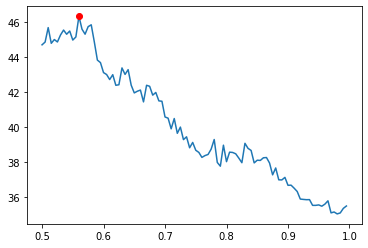

0.56


In [ ]:
total_profit_result = np.array(total_profit_result)
print('total_profit_result.shape :', total_profit_result.shape)
total_profit_sum = np.sum(total_profit_result, axis=0)
# print(total_profit_sum)

# plt.hist(x_ticks, bins=len(x_ticks),weights=total_profit_sum)
plt.plot(x_ticks, total_profit_sum)
plt.plot(x_ticks[np.argmax(total_profit_sum)], max(total_profit_sum), 'o', color='red')
plt.show()

print(x_ticks[np.argmax(total_profit_sum)])

### ***Find Best Partial***

In [ ]:
max_tp_ratio = 1.
remain_qty = 1
partial_num = 10
tp_list = list()
qty_list = list()
for i in range(partial_num, 0, -1):

  tp_list.append(max_tp_ratio * i / partial_num)
  # df['long_tp_1'] = df['ep'] + abs(df['ep'] - df['long_sl']) * tp_ratio * 2 / 3

  if i != 1:
    qty = remain_qty / 1.5
    remain_qty -= qty
  else:
    qty = remain_qty

  qty_list.append(qty)

# print(tp_list)
# print(np.array([tp_list, qty_list]).astype(np.float64))
print('total_income :', np.sum(np.prod(np.array([tp_list, qty_list]), axis=0)))

total_income : 0.9500025402631713


### ***None Realtime vs Realtime***

Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 2ms/step


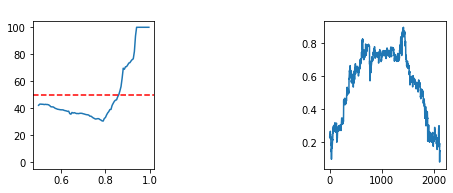

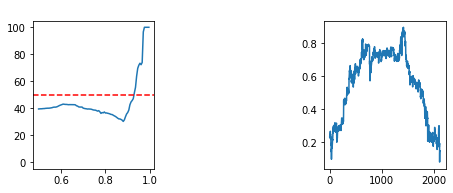


Pred by Real
65/65 [==============================] - 0s 951us/step
Pred by None Real
65/65 [==============================] - 0s 944us/step


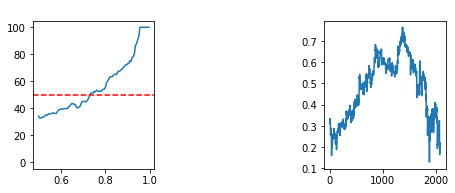

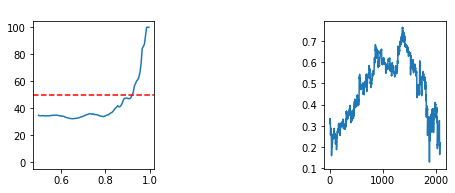


Pred by Real
65/65 [==============================] - 0s 2ms/step
Pred by None Real
65/65 [==============================] - 0s 1ms/step


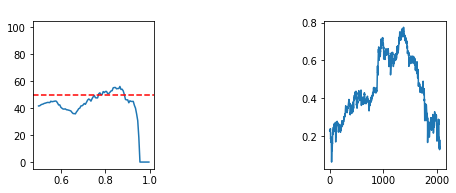

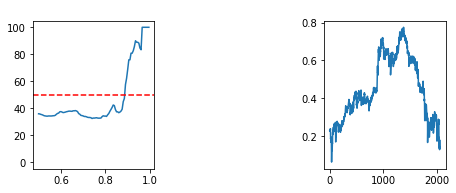


Pred by Real
67/67 [==============================] - 0s 2ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


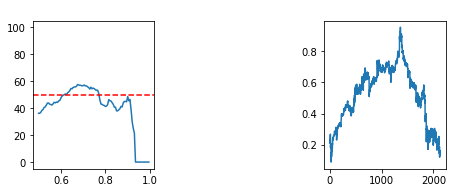

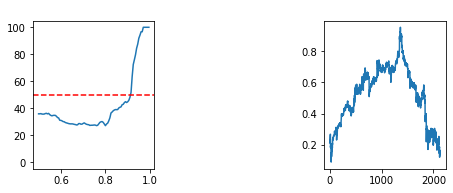


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


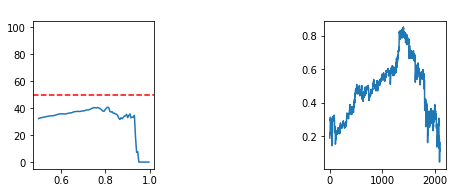

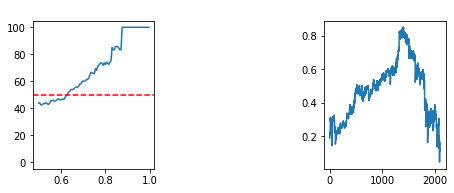


Pred by Real
68/68 [==============================] - 0s 2ms/step
Pred by None Real
68/68 [==============================] - 0s 2ms/step


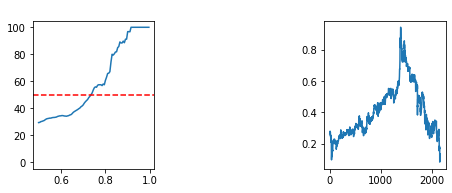

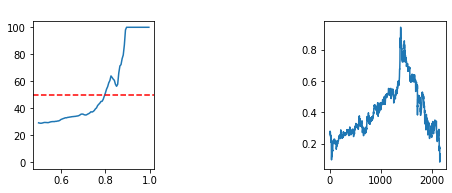


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


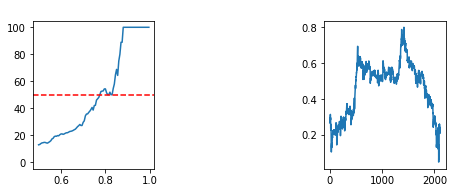

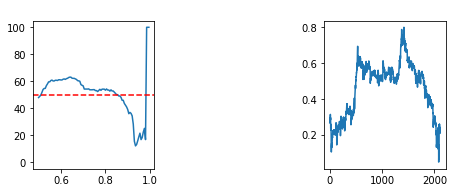


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


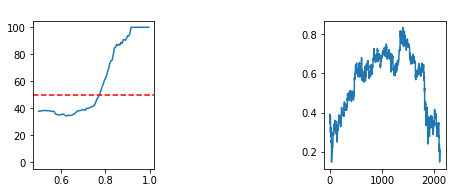

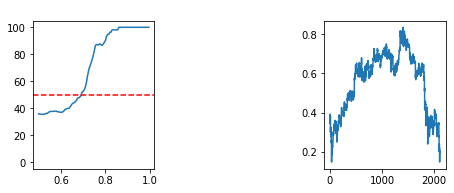


Pred by Real
Error occured :  SavedModel file does not exist at: /content/gdrive/My Drive/Colab Notebooks/Project_Stock/model/rapid_ascending 30_227_futures_rnn.hdf5/{saved_model.pbtxt|saved_model.pb}

Pred by Real
67/67 [==============================] - 0s 2ms/step
Pred by None Real
67/67 [==============================] - 0s 2ms/step


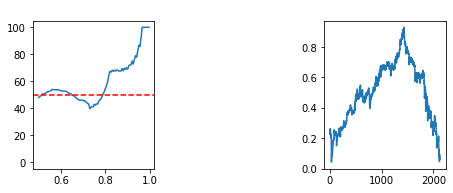

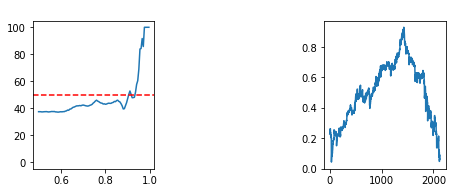


Pred by Real
66/66 [==============================] - 0s 2ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


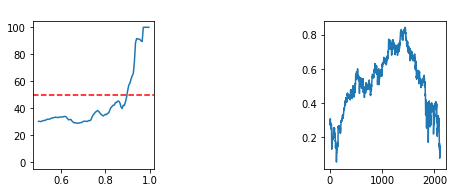

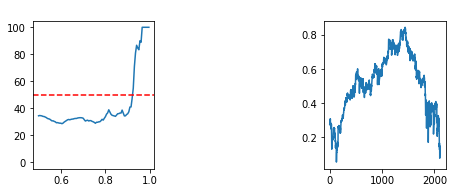


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


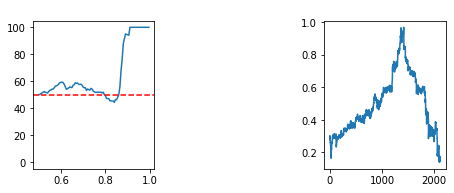

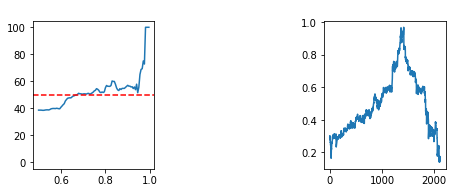


Pred by Real
65/65 [==============================] - 0s 2ms/step
Pred by None Real
65/65 [==============================] - 0s 1ms/step


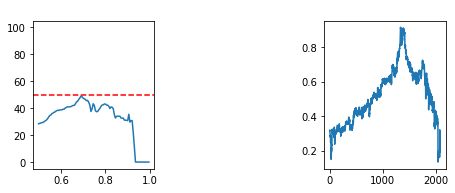

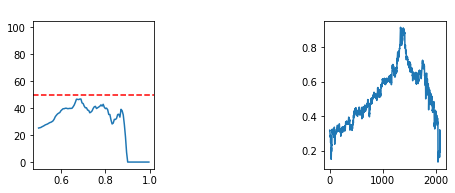


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


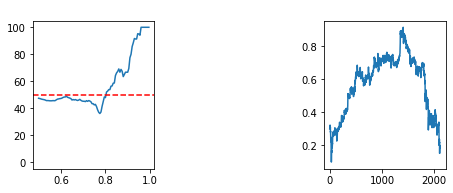

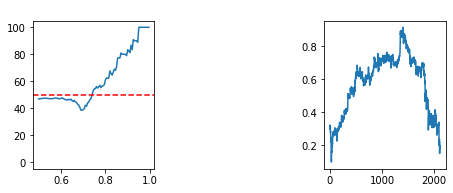


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


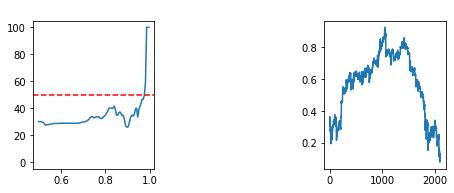

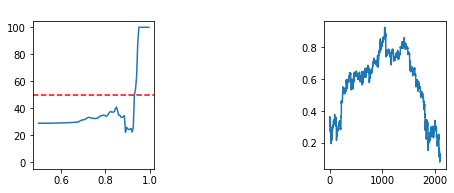


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


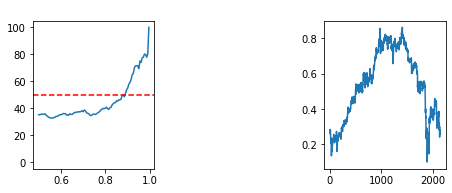

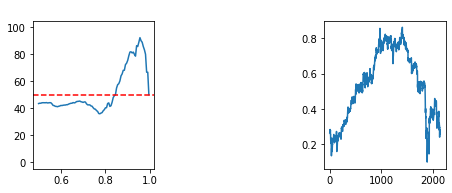


Pred by Real
64/64 [==============================] - 0s 2ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


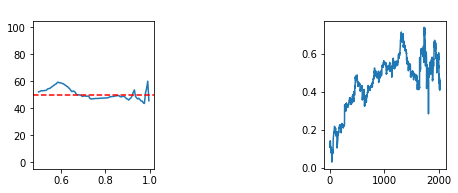

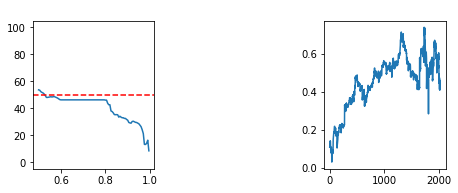


Pred by Real
63/63 [==============================] - 0s 1ms/step
Pred by None Real
63/63 [==============================] - 0s 2ms/step


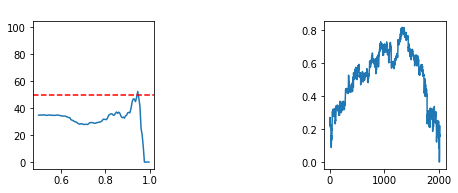

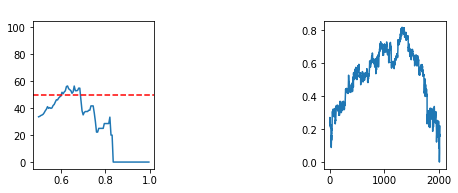


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


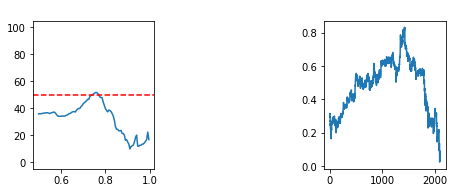

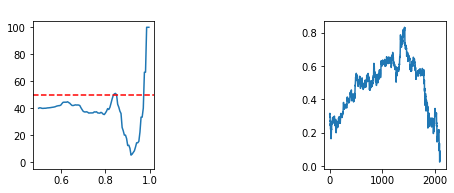


Pred by Real
63/63 [==============================] - 0s 1ms/step
Pred by None Real
63/63 [==============================] - 0s 1ms/step


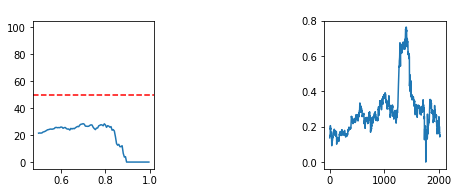

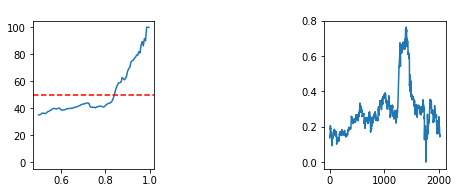


Pred by Real
64/64 [==============================] - 0s 1ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


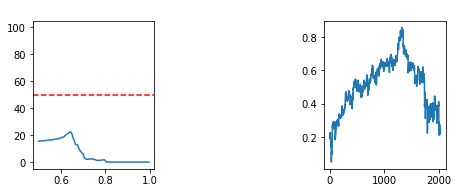

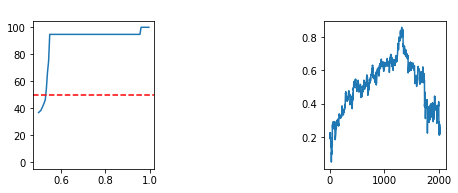


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


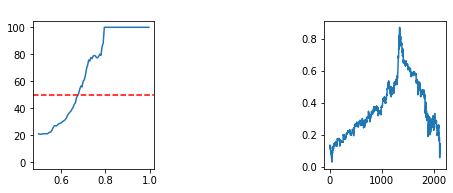

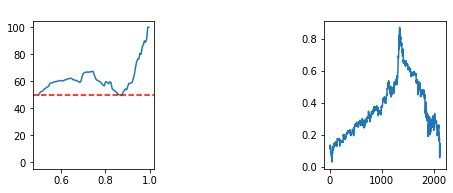


Pred by Real
65/65 [==============================] - 0s 1ms/step
Pred by None Real
65/65 [==============================] - 0s 2ms/step


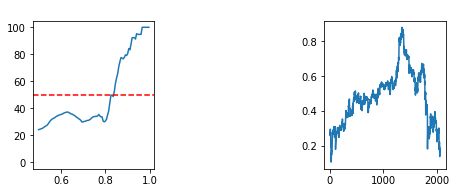

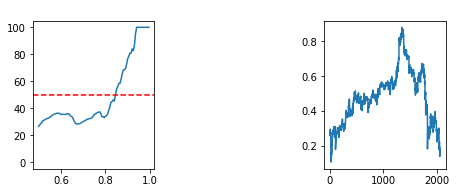


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


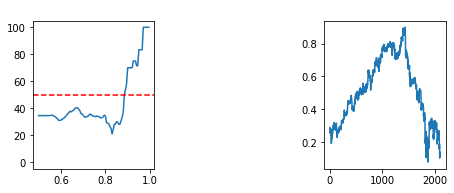

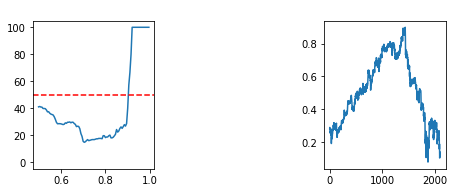


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


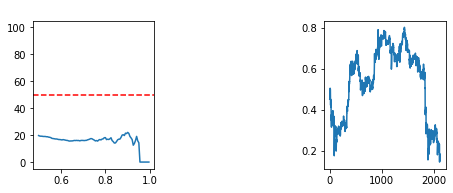

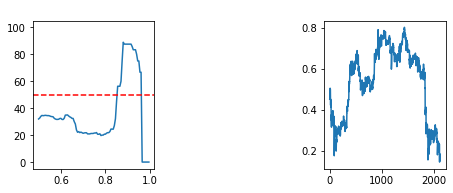


Pred by Real
69/69 [==============================] - 0s 1ms/step
Pred by None Real
69/69 [==============================] - 0s 1ms/step


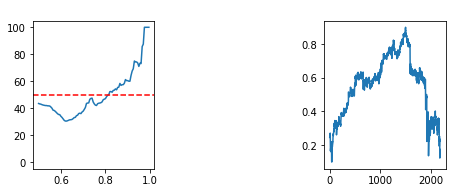

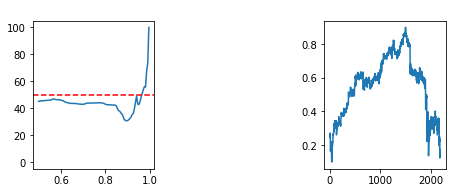


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


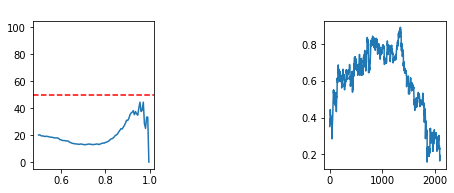

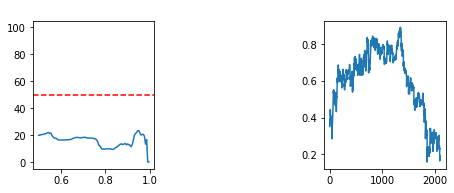


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


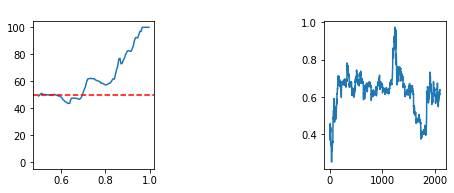

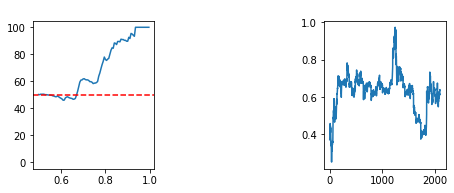


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


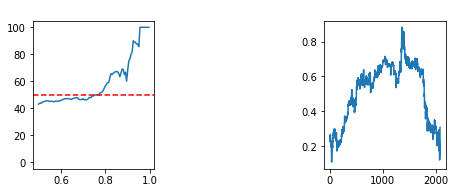

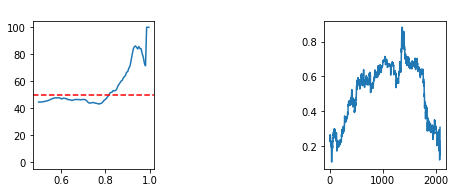


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


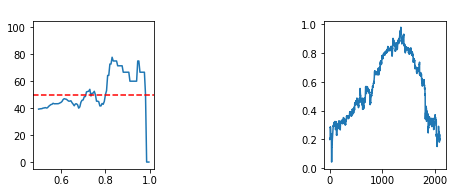

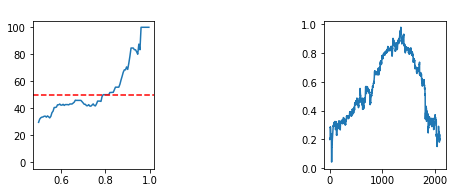


Pred by Real
68/68 [==============================] - 0s 2ms/step
Pred by None Real
68/68 [==============================] - 0s 1ms/step


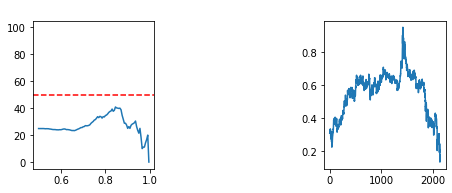

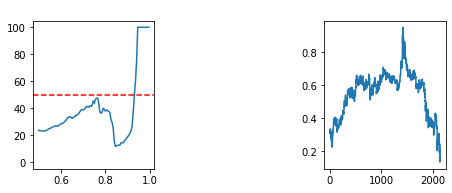


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


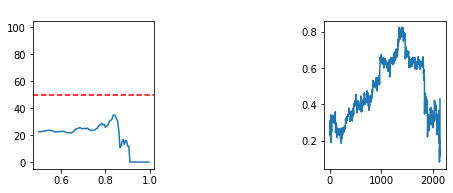

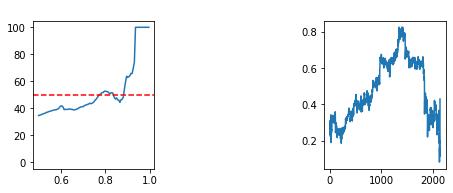


Pred by Real
64/64 [==============================] - 0s 1ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


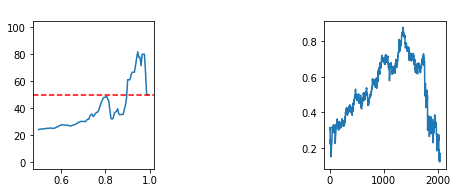

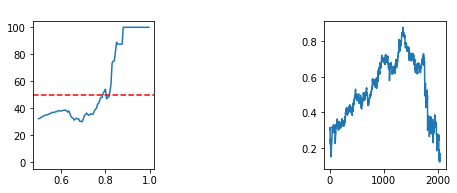


Pred by Real
66/66 [==============================] - 0s 2ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


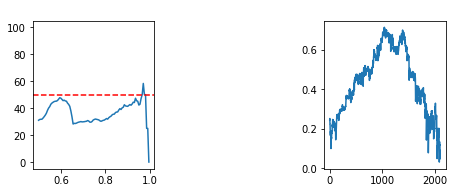

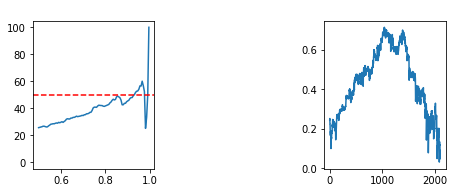


Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_376.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_377.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_378.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_379.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_380.npy'

Pred by Real
Error occured :  SavedModel file does not exist at: /content/gdrive/My Drive/Colab Notebooks/Project_Stock/model/rapid_ascending 30_258_futures_rnn.hdf5/{saved_model.pbtxt|saved_model.pb}

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Ma

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt

for model_num in model_range:

  try:

    #     Get Test Dataset   #
    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (input_data_length, model_num + 41 * 3))
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num + 41 * 3)).reshape(-1, 1)

    #       dataset 분리      #
    # dataX 구성 : VOLUME, MA, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
    # dataX 구성 : VOLUME, EMA1, EMA2, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
    # Made_X = Made_X_[:, :, [-4]]
    Made_X = Made_X_[:, :, :4]
    # print(Made_X.shape)
    # print(Made_Y.shape)
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    # X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
    #                                                   shuffle=False)

    # X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
    # X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

    X_test = Made_X.astype('float32')
    Y_test = Made_Y
    
    for model_i, model_num in enumerate([model_num, model_num + 41]):

      if model_i == 0:
        print('Pred by Real')
      else:
        print('Pred by None Real')

      model_path = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (input_data_length, model_num)
      model = load_model(model_path)
      y_pred_ = model.predict(X_test, verbose=1)
      # total_y_pred_ = model.predict(Made_X, verbose=1)

      plt.figure(figsize=(10, 6))
      
      for index, y_pred_ in enumerate([y_pred_]):

        # print('len(y_pred_) :', len(y_pred_))
        target_column = y_pred_[:, [-1]]
        # column_min, column_max = train_y_pred_.min(),train_y_pred_.max()
        column_min, column_max = target_column.min(),target_column.max()
        # print(column_min, column_max)

        x_ticks = np.arange(0.5, 1, 0.005)
        # x_ticks = np.arange(0.5, column_max, 0.005) <-- column_max 대응할만한 값을 찾아야한다. 1 까지는 사용못할것
        confidence_result = list()
        for confidence in x_ticks:
          # confidence = 0.9

          # if column_max < 0.5:
          #   break
          # else:
          #   scaled_confidence = .5 + (column_max - .5) * confidence
          scaled_confidence = column_min + (column_max - column_min) * confidence

          # scaled_confidence = confidence
          # print(scaled_confidence)
          # print('confidence :', confidence)

          y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )

          #   inverse version   #
          # confidence = 1 - confidence
          # scaled_confidence = y_pred_[:, [-1]].min() + (y_pred_[:, [-1]].max() - y_pred_[:, [-1]].min()) * confidence
          # y_pred = np.where(y_pred_[:, [-1]] <= scaled_confidence, 1, 0).reshape(-1, )

          #     결국, Categorical 은 index 값으로 value 를 나타내는 것    #
          # t_te = np.argmax(Y_val, axis=1)

          t_te = Y_test

          # print(y_pred_[:5])
          # print(Y_val[:5])
          # break

          pred_true = 0
          real_true = 0

          #       predict value 존나 높으면 True 일 확률 존나 높은건데, 그게 진짜 True가 맞냐 이걸 알고 싶은거지     #
          #       confidence를 만족하는 label이 1인 데이터 안에서 pred 1 / label 1 -> 이걸 도출해면 된다        #

          for i in range(len(y_pred)):
            if y_pred[i] == 1:  
              pred_true += 1
              if t_te[i] == y_pred[i]:
                real_true += 1

          true_true = real_true / pred_true * 100
          confidence_result.append(true_true)
          # print('True Pred / Total True : %s / %s' % (real_true, pred_true))
          # print('Accuracy : %2.f %%' % (true_true))
          # print()

        # if column_max < 0.5:
        #   continue
        
        plt.subplot(2, 4, index + 1 + model_i * 4)
        plt.plot(x_ticks, confidence_result)
        plt.axhline(50, linestyle='--', color='red')
        plt.ylim(-5, 105)
        plt.title('%s %s' % ((column_min, column_max)), color='white', fontsize=10)

        if index == 0:
          plt.subplot(2, 4, index + 3 + model_i * 4)
          plt.plot(Made_X_[:, [-1], [3]])
        elif index == 1:
          plt.subplot(2, 4, index + 3 + model_i * 4)
          plt.plot(Made_X_[:, [-1], [3]])

    plt.show()

  except Exception as e:
    print('Error occured : ', e)
  print()


### ***Check Entry points in Chart***

confidence : 0.8


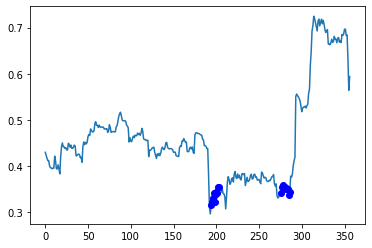

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model


confidence = 0.8
scaled_confidence = column_min + (column_max - column_min) * confidence
# print(scaled_confidence)
print('confidence :', confidence)

y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )
t_te = np.argmax(Y_val, axis=1)

close = Made_X_[-len(X_val):, [-1], [3]]
plt.plot(close)
# plt.show()

long_marker_x = list()
long_marker_y = list()
for i in range(len(y_pred)):
  if y_pred[i] == 1:  
    if t_te[i] == y_pred[i]:
      long_marker_x.append(i)
      long_marker_y.append(close[i])
      

plt.plot(long_marker_x, long_marker_y, 'o', color='blue')
plt.show()